# Tema : Fundamentos de Regresión y Modelos Estacionarios
![](src/img/logo_utb.png){width=40%} 
![](src/img/logo_etd.png){width=40%}
- **Profesor:**
- **Fernando Salcedo Mejía, Eco Msc.**
- Programa de Ciencias de Datos | Escuela de transformación digital.
- 2026-1

## Ejemplo 2 : El modelo macroeconómico del crecimiento del consumo en Estados Unidos

- Queremos modelar cómo cambia el consumo real (compra de bienes y servicios) de una economía según variables macroeconómicas importantes. El consumo es uno de los componentes más importantes de una economía.

$$
\Delta C_t = \beta_0 + \beta_1 Ingreso_t + \beta_2 Industria_t + \beta_3 Ahorro_t + \beta_4 Desempleo_t + \varepsilon_t
$$

- $\Delta C_t$ es el cambio porcentual en el gasto real de consumo personal.
- $Ingreso_t$​ es el cambio porcentual en el ingreso personal real disponible.
- $Industria_t$​ es el cambio porcentual en la producción industrial.
- $Ahorro_t$​ es el cambio porcentual en el ahorro personal.
- $Desempleo_t$​ es el cambio en la tasa de desempleo.

- Usar el archivo `US_change.csv` para modelar.


In [1]:
# Librerias necesarias

# Datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de tiempo
import statsmodels.api as sm
from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals
from fpppy.models import LinearRegression
from statsforecast import StatsForecast
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.nonparametric.smoothers_lowess import lowess

# Estadisticos
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.nonparametric.smoothers_lowess import lowess

# Utilidades
from itertools import combinations
from functools import partial
from typing import Optional


In [2]:
# Cargar datos US_change
us_change = pd.read_csv("datos/US_change.csv", parse_dates=["ds"])

# Formato
us_change["ds"] = pd.to_datetime(us_change["ds"])

# Encabezado
us_change.head()

,ds,y,Income,Production,Savings,Unemployment,unique_id
0,1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9,US_change
1,1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5,US_change
2,1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5,US_change
3,1970-10-01,-0.271848,-0.239545,-2.185691,1.169898,0.7,US_change
4,1971-01-01,1.901345,1.975925,1.909764,3.535667,-0.1,US_change


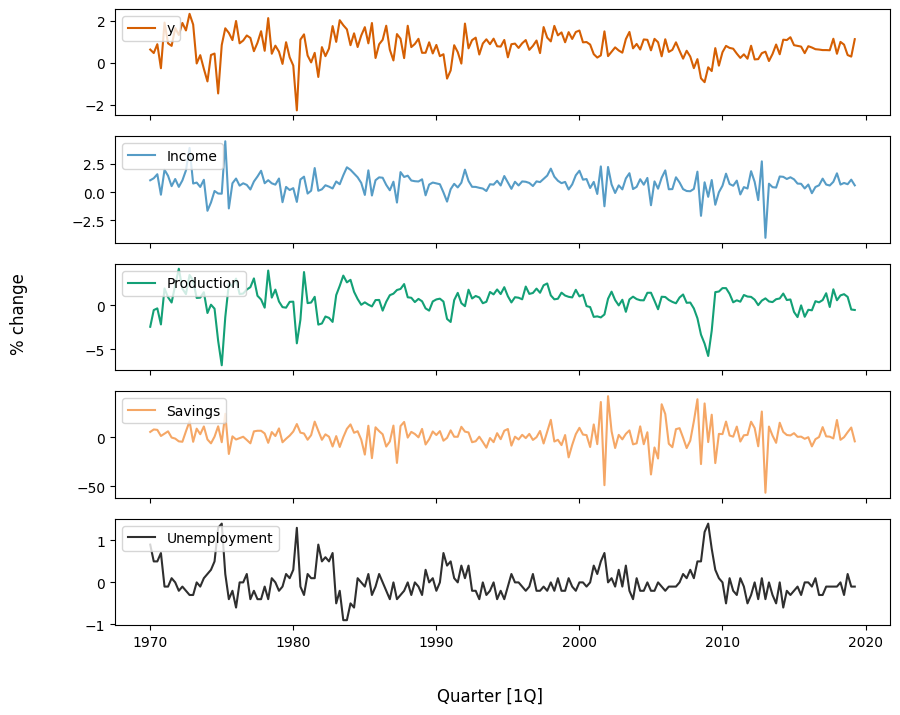

In [3]:
columns = ["y", "Income", "Production", "Savings", "Unemployment"]
colors = ["#D55F03", "#569CC6", "#13A076", "#F5A766", "#2F2F2F"]

fig, axes = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(10, 8))
for i, var in enumerate(columns):
    axes[i].plot(us_change["ds"], us_change[var], label=var, color = colors[i])
    axes[i].legend(loc='upper left')
fig.supxlabel("Quarter [1Q]")
fig.supylabel("% change")
plt.show()

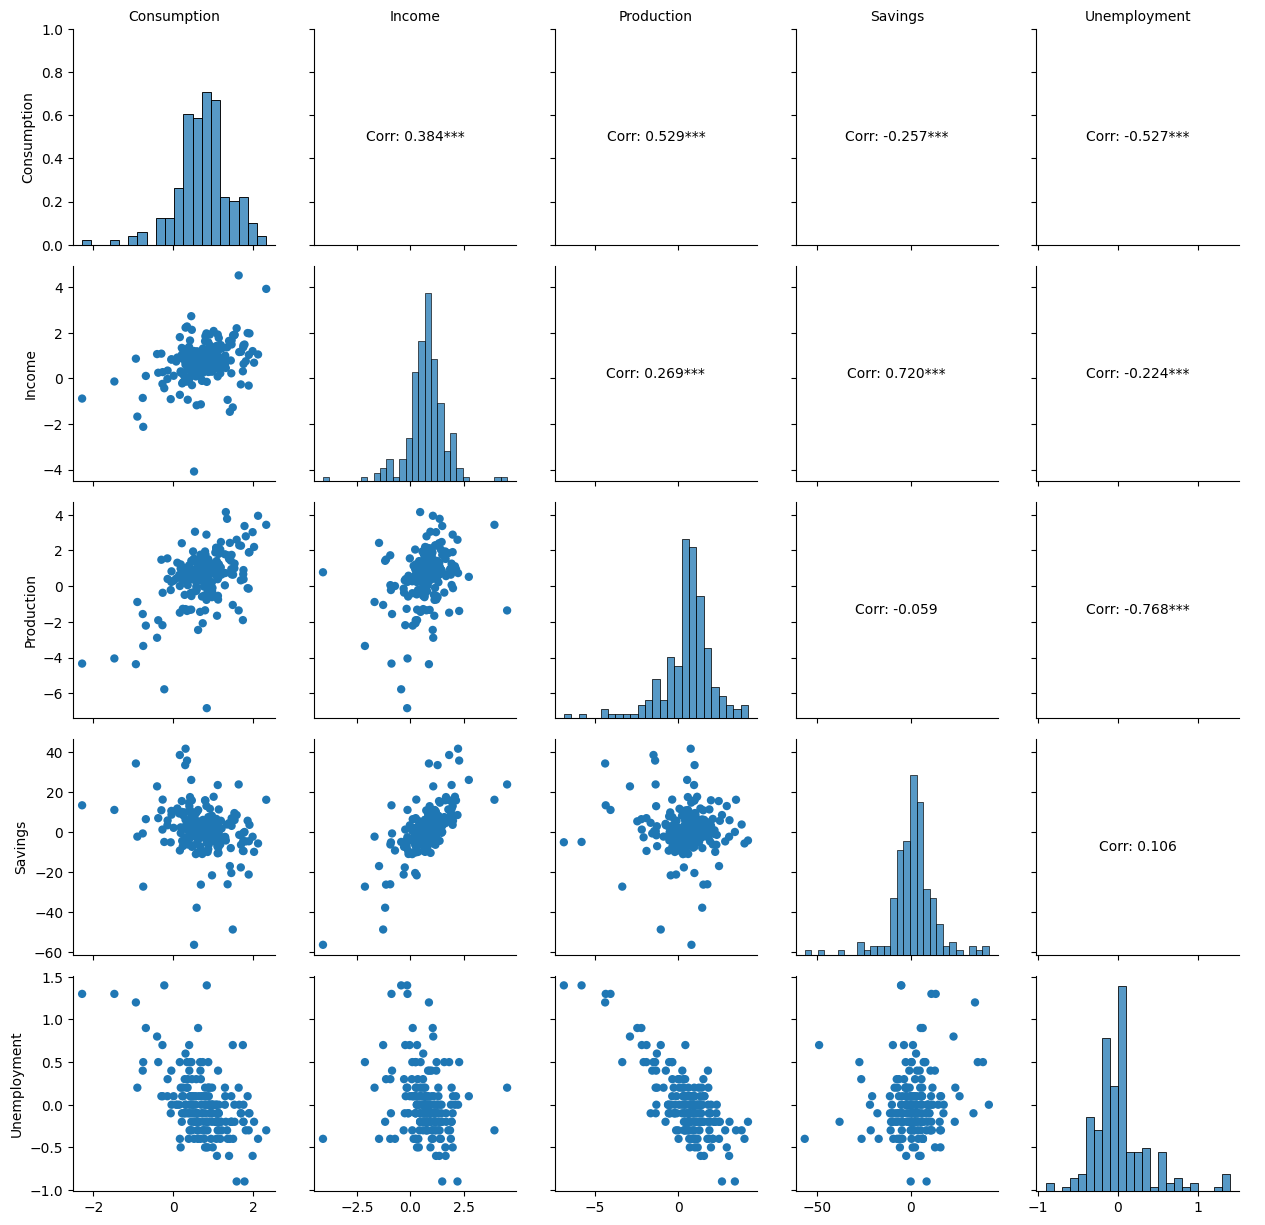

In [4]:
# Grafico de correlación exploratorio
columns = ["y", "Income", "Production", "Savings", "Unemployment"]
df = us_change[columns].rename(columns={'y': 'Consumption'})

def corrfunc(x, y, **kws):
    r, pvalue = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        f"Corr: {r:.3f}{'***' if pvalue < 0.05 else ''}",
        xy=(0.5, 0.5), xycoords="axes fraction",
        ha="center", va="center")

g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_upper(corrfunc)
g.map_lower(sns.scatterplot, edgecolor="none")
g.add_legend()
# Move x-axis labels to the top
g.set(xlabel="")
for i, col in enumerate(df.columns):
    g.axes[0, i].set_title(col, size='medium')
plt.show()

## Modelo de regresión lineal MCO por statsmodels

In [5]:
# Modelo MCO
columns = ["y", "Income", "Production", "Savings", "Unemployment"]
df = us_change[columns].rename(columns={'y': 'Consumption'})
y = df[["Consumption"]]
X = df[["Income", "Production", "Savings", "Unemployment"]]

X = sm.add_constant(X)
ml = sm.OLS(y, X).fit()
print(ml.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     160.0
Date:                Sun, 15 Feb 2026   Prob (F-statistic):           3.93e-60
Time:                        15:48:01   Log-Likelihood:                -46.660
No. Observations:                 198   AIC:                             103.3
Df Residuals:                     193   BIC:                             119.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2531      0.034      7.343   

## Interpretación del modelo

### Bondad de ajuste : 
- El modelo explica el 76.8% de la variabilidad del cambio del consumo ($R^2$). Es un ajuste aceptable como factores que han explicado la variabilidad del consumo a lo largo de la ventana de observación.
- Al estar el $\text{Adj.} R^2$ con un valor similar al $R^2$ nos indica que las variables explicativas aportan a explicar el comportamiento del cambio del consumo. 
- En su conjunto, el modelo es significativo observando el estadístico $F-statistic$ ya que es prácticamente cero.

### Análisis de coeficientes:
| Variable | Coeficiente | Significancia (p-valor) | Interpretación |
| :--- | :--- | :--- | :--- |
| const | 0.2531 | 0.000 | Si todas las variables fueran 0, el consumo crecería en promedio 0.25% trimestral. |
| Income | 0.7406 | 0.000 | En promedio, por cada 1% que sube el ingreso, el consumo sube un 0.74% trimestral. |
| Production| 0.0472 | 0.043 | Por cada 1% que sube el ingreso, el consumo sube en promedio un 0.047% trimestral. |
| Savings | -0.0529 | 0.000 | Relación inversa. Por cada 1% que sube el ingreso, en promedio el consumo se reduce en un 0.052%. |
| Unemployment| -0.1747 | 0.069 | No significativa al 5%. Su efecto en el consumo no es estadísticamente claro en este modelo. Sin embargo reporta un sentido inverso, lo cual es esperado dado que mayor desempleo, menor ingresos, menor consumo. |


## Ejercicio 3 : 

- Hacer el diagnostico del modelo macroeconómico del crecimiento del consumo en Estados Unidos. ¿Se viola algún supuesto del MCO?


### Linealidad de los parámetros

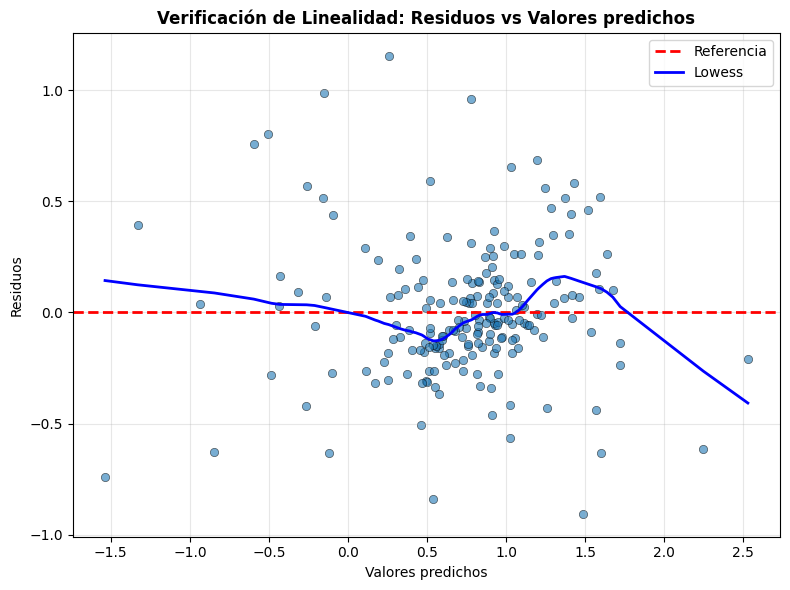

In [6]:
def check_linealidad(modelo):
    if not "statsmodels" in str(type(modelo)):
        raise TypeError("El objeto debe ser un modelo ajustado de statsmodels.")
    resid = modelo.resid
    fitted_values = modelo.fittedvalues
    
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(fitted_values, resid, alpha=0.6, edgecolors='k', linewidth=0.5)
    
    # Línea de referencia en y=0
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Referencia')
    
    # Línea de tendencia (lowess)
    smoothed = lowess(resid, fitted_values, frac=0.3)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='blue', linewidth=2, label='Lowess')
    
    # Etiquetas y título
    ax.set_xlabel('Valores predichos')
    ax.set_ylabel('Residuos')
    ax.set_title('Verificación de Linealidad: Residuos vs Valores predichos', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()

check_linealidad(modelo = ml)

**Interpretación**

- El gráfico de los valores predichos por el modelo comparados con los residuos, no muestra una relación funcional definida. Podemos concluir que existe una relación lineal de las covariables con el consumo.

### Distribución de los errores son normales

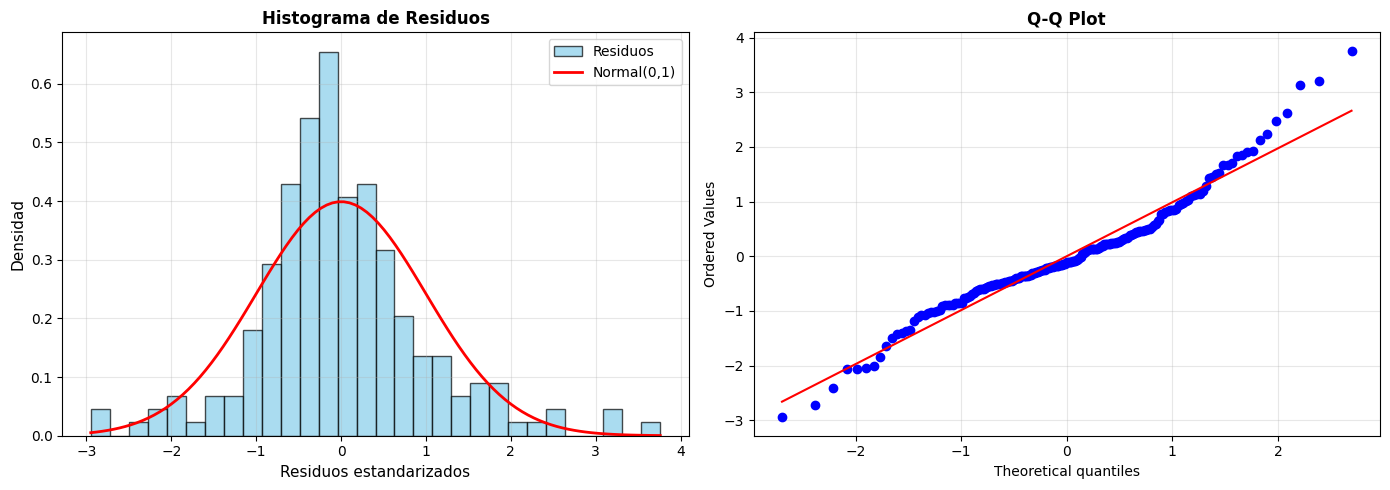

,test,estadistico,p_valor
0,Shapiro-Wilk,0.9604,0.0000
1,Jarque-Bera,35.7668,0.0000
2,Kolmogorov-Smirnov,0.0980,0.0415
3,Asimetría,0.5249,NaN
4,Curtosis,4.7981,NaN


In [7]:

def check_normalidad(modelo):    
    # Verificación del tipo de modelo
    if 'statsmodels' not in str(type(modelo)):
        raise TypeError("El objeto debe ser un modelo ajustado de statsmodels.")
    
    # Extraer residuos estandarizados
    resid = modelo.resid
    resid_std = (resid - resid.mean()) / resid.std()
    
    # Gráfico 1: Histograma con curva normal
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ax1 = axes[0]
    ax1.hist(resid_std, bins=30, density=True, alpha=0.7, 
             color='skyblue', edgecolor='black', label='Residuos')
    
    # Superponer curva normal teórica
    x = np.linspace(resid_std.min(), resid_std.max(), 100)
    ax1.plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, 
             label='Normal(0,1)')
    
    ax1.set_xlabel('Residuos estandarizados', fontsize=11)
    ax1.set_ylabel('Densidad', fontsize=11)
    ax1.set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Q-Q Plot
    ax2 = axes[1]
    stats.probplot(resid_std, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Prueba de Shapiro-Wilk
    shapiro_stat, shapiro_p = stats.shapiro(resid)
    
    # Prueba de Jarque-Bera
    jb_stat, jb_p, skew, kurtosis = jarque_bera(resid)
    
    # Prueba de Kolmogorov-Smirnov
    ks_stat, ks_p = stats.kstest(resid_std, 'norm')
    
    # Resultados
    results = {
        'test' : ['Shapiro-Wilk', 'Jarque-Bera', 'Kolmogorov-Smirnov', 'Asimetría', 'Curtosis'],
        'estadistico' : [shapiro_stat, jb_stat, ks_stat, skew, kurtosis],
        'p_valor' : [shapiro_p, jb_p, ks_p, None, None]
    }
    tab_test = pd.DataFrame(results)
    tab_test[["estadistico", "p_valor"]] = tab_test[["estadistico", "p_valor"]].apply(lambda x: round(x, 4))
    return tab_test
    

check_normalidad(modelo = ml)

**Interpretación**
- Los gráficos de distribución muestran una distribución similar a la distribución normal, pero con valores sesgados en las colas (Q-Q plot)
- El p-valor de las pruebas muestra valores por debajo de $\alpha = 0.05$. Esto rechaza la hipótesis de normalidad. Significa que los residuos no siguen una distribución normal perfecta (Histograma de los residuos).
- LA Kurtosis es mayor a 3, lo que indica que hay colas largas o valores atípicos que están afectando la distribución de los errores.

### Residuos del modelo con varianza constante (homocedasticos)

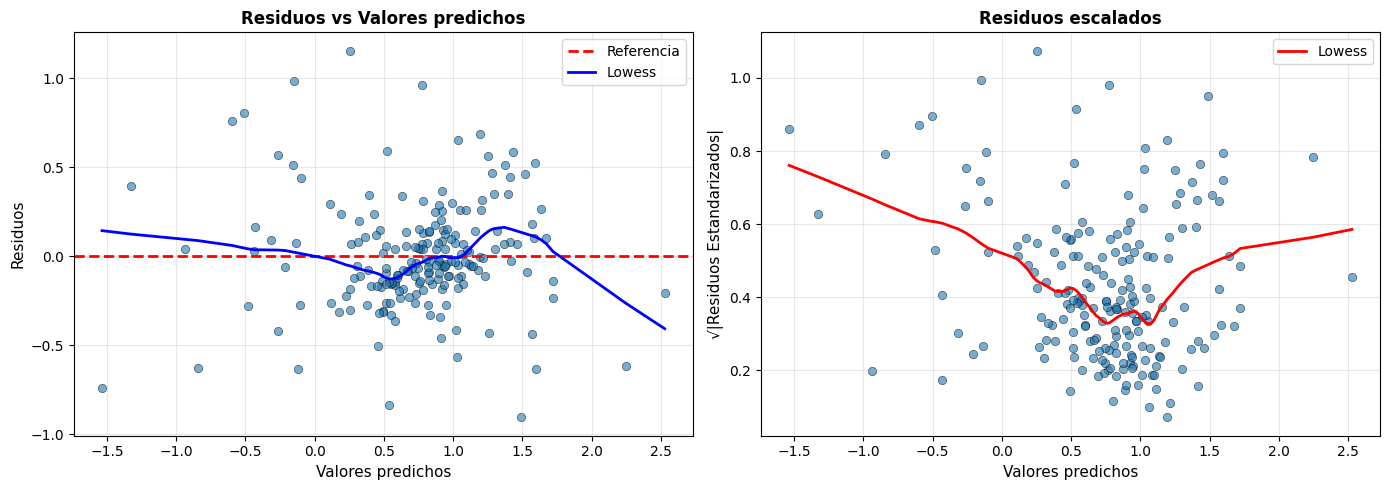

,test,estadistico,p_valor
0,Breusch-Pagan,11.1928,0.0245
1,White,70.1299,0.0000


In [8]:
def check_homocedasticidad(modelo):
    # Verificación del tipo de modelo
    if 'statsmodels' not in str(type(modelo)):
        raise TypeError("El objeto debe ser un modelo ajustado de statsmodels.")
    
    # Extraer residuos y valores predichos del modelo
    resid = modelo.resid
    fitted_values = modelo.fittedvalues
    resid_abs = np.abs(resid)
    resid_sqrt = np.sqrt(resid_abs)
    
    # Crear figuras
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico 1: Residuos vs Valores ajustados
    ax1 = axes[0]
    ax1.scatter(fitted_values, resid, alpha=0.6, edgecolors='k', linewidth=0.5)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Referencia')
    
    # Línea de tendencia
    smoothed = lowess(resid, fitted_values, frac=0.3)
    ax1.plot(smoothed[:, 0], smoothed[:, 1], color='blue', linewidth=2, label='Lowess')
    
    ax1.set_xlabel('Valores predichos', fontsize=11)
    ax1.set_ylabel('Residuos', fontsize=11)
    ax1.set_title('Residuos vs Valores predichos', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Residuos Estandarizados
    ax2 = axes[1]
    ax2.scatter(fitted_values, resid_sqrt, alpha=0.6, edgecolors='k', linewidth=0.5)
    
    # Línea de tendencia
    smoothed2 = lowess(resid_sqrt, fitted_values, frac=0.3)
    ax2.plot(smoothed2[:, 0], smoothed2[:, 1], color='red', linewidth=2, label='Lowess')
    
    ax2.set_xlabel('Valores predichos', fontsize=11)
    ax2.set_ylabel('√|Residuos Estandarizados|', fontsize=11)
    ax2.set_title('Residuos escalados', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Pruebas estadísticas
    # Obtener las variables exógenas (X) del modelo
    exog = modelo.model.exog
    
    # Prueba de Breusch-Pagan
    bp_stat, bp_p, _, _ = het_breuschpagan(resid, exog)
    
    # Prueba de White
    white_stat, white_p, _, _ = het_white(resid, exog)
    
    # Resultados
    results = {
        'test' : ['Breusch-Pagan', 'White'],
        'estadistico' : [bp_stat, white_stat],
        'p_valor' : [bp_p, white_p]
    }
    tab_test = pd.DataFrame(results)
    tab_test[["estadistico", "p_valor"]] = tab_test[["estadistico", "p_valor"]].apply(lambda x: round(x, 4))

    return tab_test


check_homocedasticidad(modelo=ml)

**Interpretación**
- Los gráficos donde se comparan los valores predichos con los residuos, no muestra una forma clara de distribución de los errores pero sí una aglomeración de los mismos o "blob-shaped". Esto indica presencia la presencia de valores extremos en las colas de la distribución de los errores tal que, los tenemos errores concentrados en una misma área y otros muy dispersos o distantes. 

- Respecto a las pruebas formales, tanto el la puerba de Breusch-Pagan y White son test para medir la heterocedasticidad. En ambos casos la prueba forma es :
    - H0: Homocedasticidad (varianza constante)
    - H1: Heterocedasticidad (varianza no constante)
- Por lo tanto con un $\alpha = 0.05$, podemos concluir que no existe evidencia de varianza constante en los residuos del modelo por lo que se descarta H0 en favor de heterocedasticidad.


### Residuos no está correlacionados

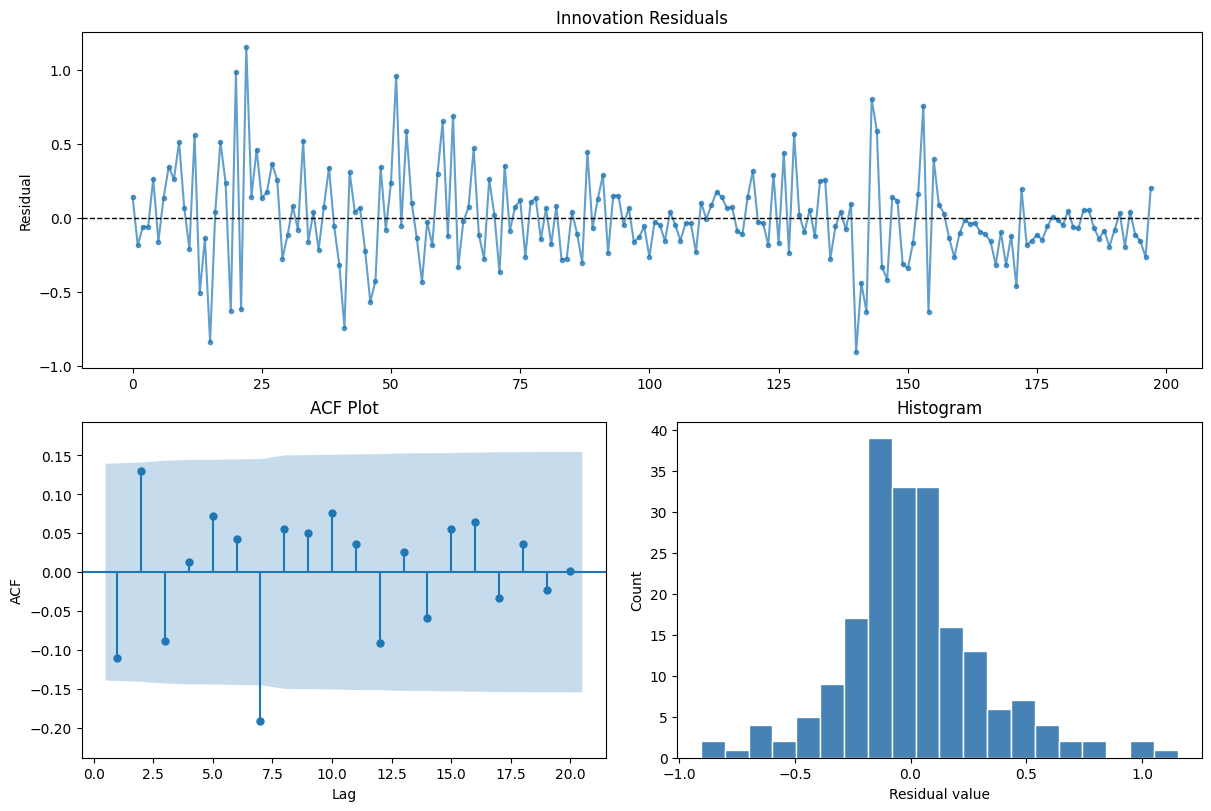

,test,estadistico,p_valor
0,Durbin-Watson,2.2180,NaN
1,Ljung-Box Test (up to lag 20),16.4758,0.0211


In [9]:
# Diagnostico del modelo
def plot_diagnostics(modelo, n_lags=None, time_axis=None):
    if not "statsmodels" in str(type(modelo)):
        raise TypeError("El objeto debe ser un modelo ajustado de statsmodels.")
    
    # Extraemos residuos directamente del objeto de resultados
    resid = modelo.resid

    # Si no se provee un eje de tiempo, usamos el índice de los residuos
    if time_axis is None:
        time_axis = resid.index

    fig, axes = plt.subplot_mosaic(
        [["resid", "resid"], ["acf", "hist"]], 
        figsize=(12, 8), 
        constrained_layout=True
    )

    # Gráfico de Residuos
    ax = axes["resid"]
    ax.plot(time_axis, resid, marker='.', linestyle='-', alpha=0.7)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set(title="Innovation Residuals", ylabel="Residual")

    # Gráfico ACF
    ax = axes["acf"]
    plot_acf(resid, ax=ax, zero=False, lags=n_lags, auto_ylims=True)
    ax.set(title="ACF Plot", xlabel="Lag", ylabel='ACF')

    # Histograma
    ax = axes["hist"]
    ax.hist(resid, bins=20, edgecolor='white', color='steelblue')
    ax.set(title="Histogram", xlabel="Residual value", ylabel="Count")
    
    plt.show()
    
    # Ljung-Box (Prueba global)
    lb_test = acorr_ljungbox(resid, lags=n_lags, return_df=True)
    min_p_value = lb_test['lb_pvalue'].min()
    lb_stat_min_pvalue = lb_test.loc[lb_test['lb_pvalue'] == min_p_value, 'lb_stat'].iloc[0]
    # Durbin-Watson (Autocorrelación de primer orden)
    dw_stat = durbin_watson(resid)

    # Resultados
    results = {
        'test' : ["Durbin-Watson", f"Ljung-Box Test (up to lag {n_lags})"],
        'estadistico' : [dw_stat, lb_stat_min_pvalue],
        'p_valor' : [None, min_p_value]
    }
    tab_test = pd.DataFrame(results)
    tab_test[["estadistico", "p_valor"]] = tab_test[["estadistico", "p_valor"]].apply(lambda x: round(x, 4))

    return tab_test

# Ejecución de la función
plot_diagnostics(modelo = ml, n_lags=20, time_axis=us_change.index)

**Interpretación**

- Análisis gráfico:
    - En el caso de el gráfico de Innovation Residuals que muestra cómo se comportan los errores a lo largo del tiempo, se observa una dispersión relativamente aleatoria alrededor de la línea cero. Sin embargo, hay clústeres de volatilidad (picos más altos al principio y cerca de la observación 150).
    - Por su parte, el ACF Plot (Autocorrelación), muestra si el error de $t$ está relacionado con el de $t-k$. En general, casi todas las barras están dentro del área azul (el intervalo de confianza), por lo que no hay evidencia de autocorrelación. Si embargo, hay un pico en el rezago 7. Al ser una serie trimestral no es claro una estacionalidad como si fuera la serie semanal (7 días), por lo que puede ser un evento inesperado en la serie (crisis, cambios de políticas, cambios de comportamiento, etc) que aún propaga su efecto hacia adelante.
- Test formales:
    - Durbin-Watson de busca autocorrelación de orden 1 $Cov(e_t, e_{t-1})$. Al estar cerca de 2.0, indica que los residuos son independientes.
    - Ljung-Box Test : El general de autocorrelación para cualquier orden muestra que existe en el rezago 7 una correlación significativa, sin embargo esta no es estacional, ya que no se repite en la serie en otro momento. En general, podemos concluir que hay autocorrelación puntual pero no estructural en el modelo.